# Parameter Tuning and Model Comparison for Idealista Listing Price Prediction 

This notebook focuses on the parameter tuning process for various machine learning models and compares their performance. 
The models considered in this analysis include:

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boosting Regression
- XGB Regression


For each model, a grid search or random search approach was applied to find the optimal hyperparameters. Following the tuning process, model performance was compared using R^2.

All these models and trained and evaluad, saving the evaluation metrics in a excel file in the folder 'modelling_comparisson_metrics' in the module 'train_and_evaluate_models.py', meanwhile the selected best model will be trained, and used to predict listing prices, and detecting undervalued prperties (where actual price is 10% lower than the predicted price) in the module 'train_and_predict_selected_model.py.

From main_evaluate_and_predict.py both models are used to save the undervaluated properties in the predict_powerbi file, where the PowerBI for exploratory analysis can also be found.

In [1]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from datetime import datetime
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from openpyxl import load_workbook
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")

## Preprocessed Dataset Import 

In [2]:
# The preprocessed dataset is readed

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
# current_date = datetime.now().strftime("%Y-%m-%d")

# Path to the preprocessed data file
# file_path = os.path.join(project_root, 'api_extract_prep', 'preprocessed_data', f'prep_data_{current_date}.csv')
file_path = os.path.join(project_root, 'api_extract_prep', 'preprocessed_data', f'prep_data_2024-12-06.csv')


df = pd.read_csv(file_path)
df.drop_duplicates()
cols = ['price'] + [col for col in df.columns if col != 'price']
df = df[cols]
columns_to_drop = ['price_m2_historical_max', 'var_from_max', 'quart_var', 'annual_var'] + [col for col in df.columns if col.startswith('neighborhood')]
df = df.drop(columns=columns_to_drop)

inicial_df = df.copy()
df 

,price,numPhotos,propertyType,size,rooms,bathrooms,distance,hasVideo,status,newDevelopment,...,amenity.score,district_Eixample,district_Gràcia,district_Horta Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi
0,249000,22,1,55.0,2,1,3905,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,749000,40,1,118.0,2,2,3472,1,1,0,...,7,0,0,0,0,0,0,0,0,1
2,330000,39,1,69.0,2,1,2888,0,1,0,...,4,0,1,0,0,0,0,0,0,0
3,749000,32,1,118.0,2,2,3578,1,1,0,...,4,0,0,0,0,0,0,0,0,1
4,479000,26,1,105.0,4,1,2237,0,1,0,...,4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,315000,18,1,62.0,2,1,5174,1,1,0,...,3,0,0,0,0,0,1,0,0,0
2841,198000,24,1,40.0,1,1,1144,1,1,0,...,5,0,0,0,0,0,0,0,0,0
2842,472000,28,1,85.0,1,1,3647,1,1,0,...,4,0,0,0,0,0,0,1,0,0
2843,475000,26,1,78.0,2,2,962,1,1,0,...,3,0,0,0,0,0,0,0,0,0


## Linear Exploratory Analysis 

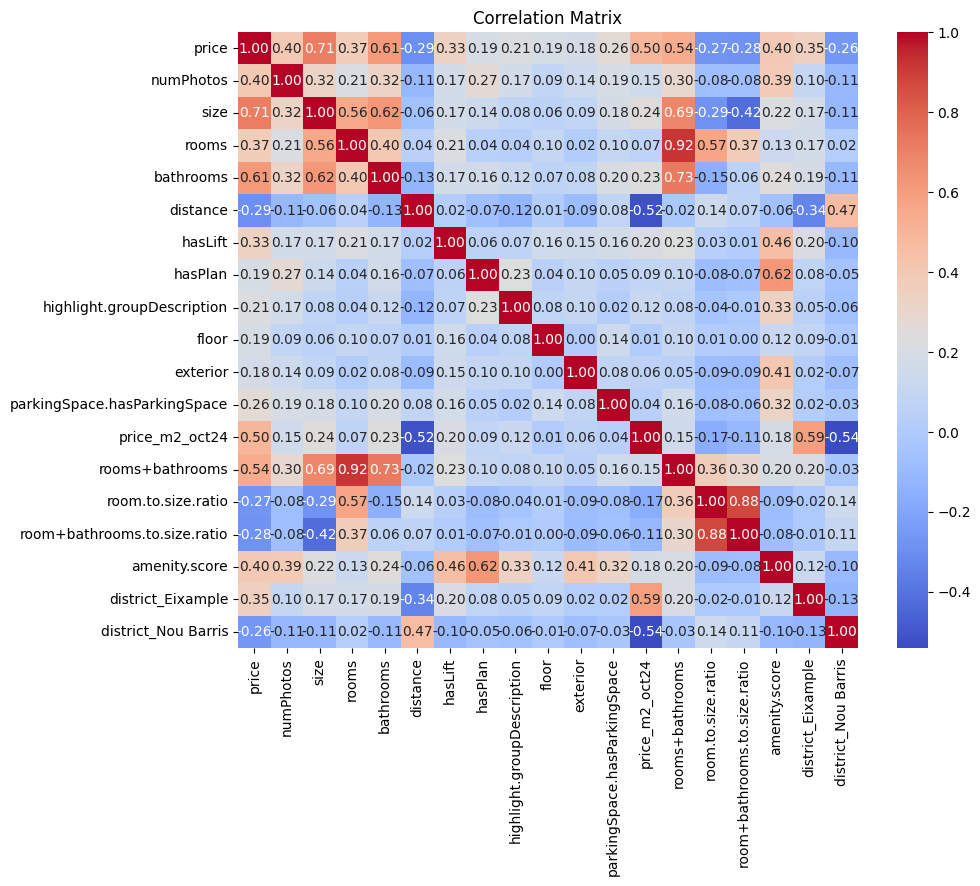

Variables highly correlated with Price (correlation > 0.18 or < -0.18):
price: 1.0000
numPhotos: 0.3988
size: 0.7141
rooms: 0.3732
bathrooms: 0.6124
distance: -0.2945
hasLift: 0.3341
hasPlan: 0.1900
highlight.groupDescription: 0.2126
floor: 0.1919
exterior: 0.1812
parkingSpace.hasParkingSpace: 0.2627
price_m2_oct24: 0.4974
rooms+bathrooms: 0.5400
room.to.size.ratio: -0.2745
room+bathrooms.to.size.ratio: -0.2798
amenity.score: 0.3966
district_Eixample: 0.3462
district_Nou Barris: -0.2630


In [3]:
# The correlation matrix from the previous dataset is ploted

def plot_high_corr_matrix(df: pd.DataFrame, target_variable: str = 'price', threshold: float = 0.3):
    """
    Compute and plot the correlation matrix for variables highly correlated with the target variable.

    Parameters:
    - df: DataFrame containing the data.
    - target_variable: The target variable to correlate with (default is 'price').
    - threshold: The correlation threshold to consider as "highly correlated" (default is 0.3).
    """
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify variables strongly correlated with the target variable (positive or negative)
    target_correlation = correlation_matrix[target_variable]
    high_corr_vars = target_correlation[(target_correlation > threshold) | (target_correlation < -threshold)].index

    # Subset the correlation matrix to include only relevant variables
    filtered_corr_matrix = correlation_matrix.loc[high_corr_vars, high_corr_vars]

    # Plot the filtered correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title(f'Correlation Matrix')
    plt.show()

    # Print the highly correlated variables and their correlation values
    print(f"Variables highly correlated with {target_variable.capitalize()} (correlation > {threshold} or < {-threshold}):")
    for var in high_corr_vars:
        print(f"{var}: {target_correlation[var]:.4f}")


plot_high_corr_matrix(df, target_variable='price', threshold=0.18)


In [4]:
# Other variables that should be important
df[['price','rooms',
 'floor', 'status', 'propertyType', 'highlight.groupDescription', 'distance', 'exterior', 'parkingSpace.hasParkingSpace', 'hasPlan', 'topPlus']].corr()

,price,rooms,floor,status,propertyType,highlight.groupDescription,distance,exterior,parkingSpace.hasParkingSpace,hasPlan,topPlus
price,1.000000,0.373228,0.191878,0.008597,0.107587,0.212556,-0.294508,0.181230,0.262714,0.189956,0.150037
rooms,0.373228,1.000000,0.097590,0.119321,0.025963,0.036071,0.044320,0.017202,0.097581,0.040343,0.041489
floor,0.191878,0.097590,1.000000,-0.008550,0.395156,0.075244,0.014403,0.003857,0.144292,0.044445,0.035296
status,0.008597,0.119321,-0.008550,1.000000,0.000904,-0.011014,0.038185,0.001059,0.038274,0.074473,-0.006160
propertyType,0.107587,0.025963,0.395156,0.000904,1.000000,0.012479,0.155568,-0.097077,0.037288,0.036666,-0.003208
highlight.groupDescription,0.212556,0.036071,0.075244,-0.011014,0.012479,1.000000,-0.121545,0.102763,0.020950,0.225768,0.336539
distance,-0.294508,0.044320,0.014403,0.038185,0.155568,-0.121545,1.000000,-0.093918,0.081859,-0.074291,-0.065263
exterior,0.181230,0.017202,0.003857,0.001059,-0.097077,0.102763,-0.093918,1.000000,0.084326,0.099828,0.029884
parkingSpace.hasParkingSpace,0.262714,0.097581,0.144292,0.038274,0.037288,0.020950,0.081859,0.084326,1.000000,0.049396,-0.002462
hasPlan,0.189956,0.040343,0.044445,0.074473,0.036666,0.225768,-0.074291,0.099828,0.049396,1.000000,0.096654


In [5]:
# The Vif is calculated to adress colineality

def calculate_vif(df: pd.DataFrame, predictors: list):
    """
    Calculate and display the Variance Inflation Factor (VIF) for each predictor variable.
    
    Parameters:
    - df: DataFrame containing the data.
    - predictors: List of predictor variables (independent variables) to calculate VIF for.
    
    Returns:
    - vif_data: DataFrame containing the VIF values for each predictor.
    """
    # Select the independent variables (predictors)
    X = df[predictors]

    # Add constant (intercept term)
    X = add_constant(X)

    # Calculate the VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Print the VIF values
    print("Variance Inflation Factor (VIF) for each predictor:")
    print(vif_data)

    return vif_data

predictors = [
    'price', 
    'numPhotos', 
    'size', 
    'rooms', 
    'bathrooms', 
    'distance', 
    'hasLift', 
    'hasPlan', 
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'room.to.size.ratio', 
    'room+bathrooms.to.size.ratio', 
    'amenity.score', 
    'district_Eixample', 
    'district_Nou Barris'
]
vif_data = calculate_vif(df, predictors)


Variance Inflation Factor (VIF) for each predictor:
                        Variable         VIF
0                          const  165.914671
1                          price    3.750736
2                      numPhotos    1.326031
3                           size   12.337960
4                          rooms         inf
5                      bathrooms         inf
6                       distance    1.661209
7                        hasLift    1.615673
8                        hasPlan    2.058643
9     highlight.groupDescription    1.188238
10                         floor    1.111275
11                      exterior    1.320259
12  parkingSpace.hasParkingSpace    1.279787
13                price_m2_oct24    2.938385
14               rooms+bathrooms         inf
15            room.to.size.ratio   27.224089
16  room+bathrooms.to.size.ratio   23.724655
17                 amenity.score    3.608341
18             district_Eixample    1.831949
19           district_Nou Barris    1.708452


In [6]:
# VIF excluding highly colinear variables

predictors =  [
    'numPhotos', 
    'size', 
    'distance', 
    'hasLift', 
    'hasPlan', 
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'amenity.score', 
    'district_Eixample', 
    'district_Nou Barris'
]
vif_data = calculate_vif(df, predictors)


Variance Inflation Factor (VIF) for each predictor:
                        Variable        VIF
0                          const  78.483415
1                      numPhotos   1.299244
2                           size   2.049278
3                       distance   1.591113
4                        hasLift   1.563549
5                        hasPlan   2.042350
6     highlight.groupDescription   1.169972
7                          floor   1.061504
8                       exterior   1.307792
9   parkingSpace.hasParkingSpace   1.247971
10                price_m2_oct24   2.589239
11               rooms+bathrooms   2.012123
12                 amenity.score   3.586129
13             district_Eixample   1.792698
14           district_Nou Barris   1.694325


In [7]:
# Function for Multivariate Linear Regression

def multivariate_linear_regression(df: pd.DataFrame, scale_features=True, scale_target=True):
    """
    Perform multivariate linear regression on the given DataFrame with optional scaling for predictors and target.
    
    Parameters:
    - df: DataFrame containing the data. It should include predictor variables and the target variable 'price'.
    - scale_features: Whether to scale predictor variables (default: True).
    - scale_target: Whether to scale the target variable 'price' (default: True).
    
    Returns:
    - summary_df: DataFrame containing coefficients, standard errors, p-values, and significance stars for the regression.
    - r2: R-squared value of the regression.
    - r2_adj: Adjusted R-squared value of the regression.
    - mape: Mean Absolute Percentage Error of the model.
    """
    # Define the features
    features = [
    'numPhotos', 
    'size', 
    'distance', 
    'hasLift', 
    'hasPlan', 
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'amenity.score', 
    'district_Eixample', 
    'district_Nou Barris'
]
    
    # Prepare feature matrix and target variable
    X = df[features]
    y = df['price']
    
    # Scale features if required
    if scale_features:
        scaler_features = StandardScaler()
        X = scaler_features.fit_transform(X)
    else:
        X = X.values  # Convert to numpy array without scaling
    
    # Scale target variable if required
    if scale_target:
        scaler_target = StandardScaler()
        y = scaler_target.fit_transform(y.values.reshape(-1, 1)).flatten()
    else:
        y = y.values  # Keep original target values
    
    # Add intercept (constant term)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit()

    # Get the coefficients, standard errors, and p-values
    coefficients = results.params
    standard_errors = results.bse
    p_values = results.pvalues

    # Create a DataFrame to show all results
    summary_df = pd.DataFrame({
        'Variable': ['Intercept'] + features,
        'Coefficient': coefficients,
        'Standard Error': standard_errors,
        'P-value': p_values
    })

    # Add significance stars based on p-value
    def significance_stars(p_value):
        if p_value < 0.01:
            return '***'
        elif p_value < 0.05:
            return '**'
        elif p_value < 0.1:
            return '*'
        else:
            return ''

    summary_df['Significance'] = summary_df['P-value'].apply(significance_stars)

    # Calculate R-squared and Adjusted R-squared
    r2 = results.rsquared
    r2_adj = results.rsquared_adj

    # Calculate Mean Absolute Percentage Error (MAPE)
    predictions = results.predict(X)
    if scale_target:
        predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
        y = scaler_target.inverse_transform(y.reshape(-1, 1)).flatten()
    
    mape = np.mean(np.abs((y - predictions) / y)) * 100

    return summary_df, r2, r2_adj, mape


# Example Usage
# Assuming `df` is a pandas DataFrame with the necessary columns:
summary_df, r2, r2_adj, mape = multivariate_linear_regression(df, scale_features=True, scale_target=False)

# Print the results
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {r2_adj}")
print(f"MAPE: {mape}%")


R-squared: 0.7152407614154763
Adjusted R-squared: 0.713832058468415
MAPE: 21.73787569343434%


In [8]:
summary_df

,Variable,Coefficient,Standard Error,P-value,Significance
0,Intercept,413693.672759,1873.201939,0.000000e+00,***
1,numPhotos,15361.355993,2135.157788,7.992932e-13,***
2,size,98906.489124,2681.544477,1.586122e-243,***
3,distance,-24016.188498,2362.844589,7.328721e-24,***
4,hasLift,19372.933303,2342.288505,2.020170e-16,***
5,hasPlan,-3646.245869,2677.007952,1.732873e-01,
6,highlight.groupDescription,13360.278382,2026.153637,5.092234e-11,***
7,floor,19837.939850,1929.947404,2.336073e-24,***
8,exterior,6993.323100,2142.170254,1.109254e-03,***
9,parkingSpace.hasParkingSpace,16071.076870,2092.603362,2.177278e-14,***


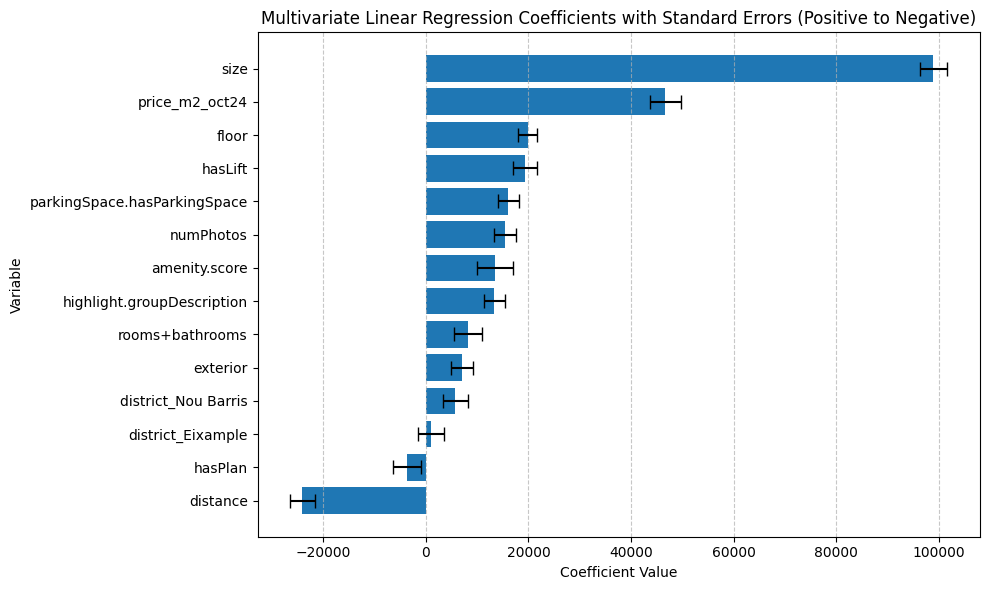

In [9]:
# Filter out the intercept (constant term)
summary_df_no_intercept = summary_df[summary_df['Variable'] != 'Intercept']

# Sort the DataFrame by the coefficient values (positive to negative)
summary_df_sorted = summary_df_no_intercept.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients with error bars (Standard Errors)
plt.figure(figsize=(10, 6))
plt.barh(
    summary_df_sorted['Variable'],  # Use variable names for the y-axis
    summary_df_sorted['Coefficient'],
    xerr=summary_df_sorted['Standard Error'],
    capsize=5
)
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Multivariate Linear Regression Coefficients with Standard Errors (Positive to Negative)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


## Multivariate Linear Regression Models
 - Hyperparameter Tunning
 - Feature Importance

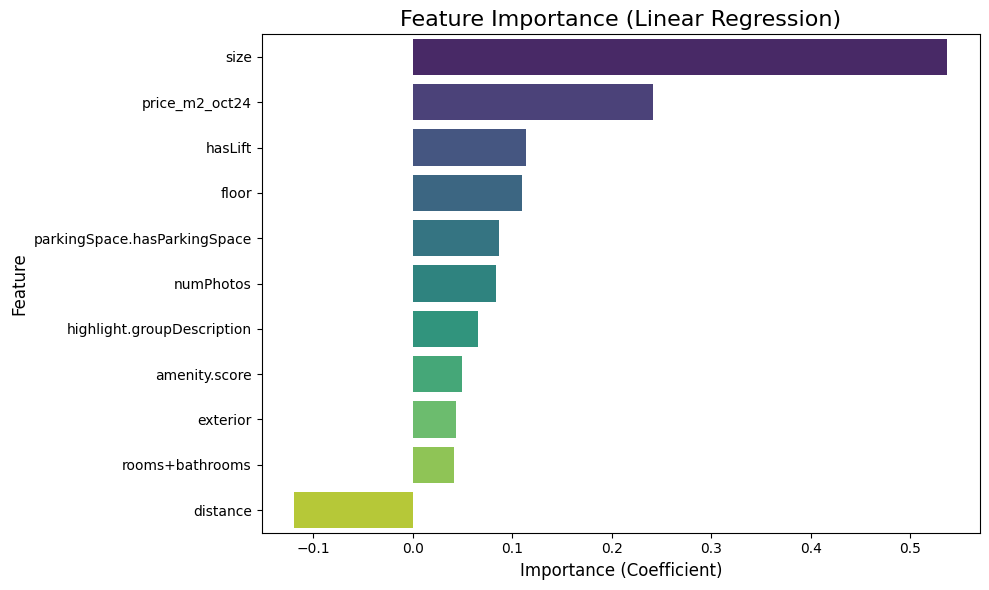

MAPE (Train): 21.92%
MAPE (Test): 22.55%
R² (Train): 0.7113
R² (Test): 0.7248

Feature Importance:
                         Feature  Importance
1                           size    0.537338
8                 price_m2_oct24    0.241958
3                        hasLift    0.113924
5                          floor    0.110179
7   parkingSpace.hasParkingSpace    0.086366
0                      numPhotos    0.083938
4     highlight.groupDescription    0.065641
10                 amenity.score    0.049328
6                       exterior    0.043882
9                rooms+bathrooms    0.041018
2                       distance   -0.119107


In [10]:
# Multivariate Linear Regression with feature importance

def scale_train_and_visualize(df, features_to_scale, target_column, test_size=0.2, random_state=42):
    """
    Scales features and target, trains a Linear Regression model, evaluates it, 
    and returns metrics, feature importance, and a visualization of feature importance.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the dataset.
        features_to_scale (list): List of feature column names to scale.
        target_column (str): The target column name.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).
    
    Returns:
        dict: A dictionary containing metrics and feature importance.
    """
    # Create scalers for features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    # Scale the features
    X = df[features_to_scale]
    X_scaled = scaler_features.fit_transform(X)
    
    # Scale the target variable
    y = df[target_column]
    y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_state)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train_scaled = model.predict(X_train)
    y_pred_test_scaled = model.predict(X_test)
    
    # Inverse transform the scaled target values
    y_train_original = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_pred_train_original = scaler_target.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_test_original = scaler_target.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mape_train = mean_absolute_percentage_error(y_train_original, y_pred_train_original)
    mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': features_to_scale,
        'Importance': model.coef_.flatten()
    })
    feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_sorted, palette='viridis')
    plt.title('Feature Importance (Linear Regression)', fontsize=16)
    plt.xlabel('Importance (Coefficient)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Results dictionary
    results = {
        "MAPE_Train": mape_train * 100,
        "MAPE_Test": mape_test * 100,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Feature_Importance": feature_importance_sorted
    }
    
    return results

features_to_scale = [
    'numPhotos', 
    'size', 
    'distance', 
    'hasLift',  
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'amenity.score'
]

results = scale_train_and_visualize(df, features_to_scale, target_column='price')

# Print results
print(f"MAPE (Train): {results['MAPE_Train']:.2f}%")
print(f"MAPE (Test): {results['MAPE_Test']:.2f}%")
print(f"R² (Train): {results['R2_Train']:.4f}")
print(f"R² (Test): {results['R2_Test']:.4f}")
print("\nFeature Importance:")
print(results['Feature_Importance'])


In [11]:
# Train and evaluate Ridge, Lasso, and ElasticNet

def train_and_evaluate_models(df, features_to_scale, target_column, test_size=0.2, random_state=42):
    """
    Train and evaluate Ridge, Lasso, and ElasticNet models with hyperparameter tuning and feature importance visualization.
    
    Parameters:
        df (pd.DataFrame): The input dataset.
        features_to_scale (list): List of feature column names to scale.
        target_column (str): The name of the target variable column.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).
        
    Returns:
        dict: A dictionary containing model results and feature importance for each model.
    """
    # Scale features and target
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    X = df[features_to_scale]
    X_scaled = scaler_features.fit_transform(X)
    
    y = df[target_column]
    y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_state)
    
    # Define models
    models = {
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet()
    }
    
    # Define hyperparameter grids
    param_grid = {
        'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
        'Lasso': {'alpha': [0.1, 0.5, 1.0, 10.0, 100.0]},
        'ElasticNet': {'alpha': [0.1, 0.5, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
    }
    
    # Results dictionary
    results = {}
    
    for model_name, model in models.items():
        print(f"Running {model_name} model...")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        print(f"{model_name} Cross-validation scores (R-squared): {cv_scores}")
        print(f"{model_name} Average CV score: {cv_scores.mean():.4f}")
        
        # GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        
        # Best hyperparameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        print(f"{model_name} Best parameters from grid search: {best_params}")
        
        # Train the best model
        best_model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train_scaled = best_model.predict(X_train)
        y_pred_test_scaled = best_model.predict(X_test)
        
        # Inverse transform scaled target
        y_train_original = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_pred_train_original = scaler_target.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_test_original = scaler_target.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
        
        # Metrics
        mape_train = mean_absolute_percentage_error(y_train_original, y_pred_train_original)
        mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original)
        r2_train = best_model.score(X_train, y_train)
        r2_test = best_model.score(X_test, y_test)
        
        print(f"{model_name} MAPE (Train): {mape_train * 100:.2f}%")
        print(f"{model_name} MAPE (Test): {mape_test * 100:.2f}%")
        print(f"{model_name} R-squared (Train): {r2_train:.4f}")
        print(f"{model_name} R-squared (Test): {r2_test:.4f}")
        
        # Feature Importance
        feature_importance = pd.DataFrame({
            'Feature': features_to_scale,
            'Importance': best_model.coef_.flatten()
        })
        
        # Sort by importance
        feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)
        
        # Store results
        results[model_name] = {
            'Best_Params': best_params,
            'MAPE_Train': mape_train * 100,
            'MAPE_Test': mape_test * 100,
            'R2_Train': r2_train,
            'R2_Test': r2_test,
            'Feature_Importance': feature_importance_sorted
        }
    
    return results


features_to_scale = [
    'numPhotos', 
    'size', 
    'distance', 
    'hasLift',  
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'amenity.score'
]


model_results = train_and_evaluate_models(df, features_to_scale, target_column='price')

# Display results
for model_name, metrics in model_results.items():
    print(f"\n{model_name} Results:")
    print(f"Best Parameters: {metrics['Best_Params']}")
    print(f"MAPE (Train): {metrics['MAPE_Train']:.2f}%")
    print(f"MAPE (Test): {metrics['MAPE_Test']:.2f}%")
    print(f"R² (Train): {metrics['R2_Train']:.4f}")
    print(f"R² (Test): {metrics['R2_Test']:.4f}")
    print("Feature Importance:")
    print(metrics['Feature_Importance'])


Running Ridge model...
Ridge Cross-validation scores (R-squared): [0.71010646 0.72745605 0.70527623 0.66958036 0.71359865]
Ridge Average CV score: 0.7052
Ridge Best parameters from grid search: {'alpha': 10.0}
Ridge MAPE (Train): 21.92%
Ridge MAPE (Test): 22.54%
Ridge R-squared (Train): 0.7113
Ridge R-squared (Test): 0.7250
Running Lasso model...
Lasso Cross-validation scores (R-squared): [-0.00271101 -0.0033772  -0.00235566 -0.00011469 -0.0025724 ]
Lasso Average CV score: -0.0022
Lasso Best parameters from grid search: {'alpha': 0.1}
Lasso MAPE (Train): 24.69%
Lasso MAPE (Test): 26.45%
Lasso R-squared (Train): 0.6646
Lasso R-squared (Test): 0.6759
Running ElasticNet model...
ElasticNet Cross-validation scores (R-squared): [0.18972012 0.17415876 0.17822693 0.20651751 0.19624494]
ElasticNet Average CV score: 0.1890
ElasticNet Best parameters from grid search: {'alpha': 0.1, 'l1_ratio': 0.1}
ElasticNet MAPE (Train): 22.10%
ElasticNet MAPE (Test): 22.57%
ElasticNet R-squared (Train): 0.70

Ridge, Lasso, and ElasticNet models have not been selected, due to not improving R^2 or MAPE

## Non Linear Regression Models
 - Hyperparameter Tunning
 - Feature Importance

In [12]:
# Evaluate different hyperparameters that not produce high overfitting

# Function to perform Randomized Search and evaluate models
def hyperparameter_tuning_and_evaluation(X_train, y_train, X_test, y_test, model_type):
    """Function to tune hyperparameters and evaluate a model based on R²."""

    # Define the model based on the input model_type
    if model_type == 'decision_tree':
        model = DecisionTreeRegressor()
        param_dist = {
            'max_depth': [3, 4, 5, 6],  # Limit tree depth to avoid overfitting
            'min_samples_split': [10, 20, 30],  # Require more samples to split
            'min_samples_leaf': [5, 10, 15],  # Ensure sufficient samples in leaf nodes
        }

    elif model_type == 'random_forest':
        model = RandomForestRegressor()
        param_dist = {
            'n_estimators': [100, 150],  # Fewer trees to prevent overfitting
            'max_depth': [5, 10, 15],  # Moderate depth to balance complexity
            'min_samples_split': [10, 20],  # Larger splits to generalize better
            'min_samples_leaf': [5, 10],  # Ensure leaves aren't too small
            'max_features': ['sqrt', 'log2'],  # Limit the number of features used in splits
        }

    elif model_type == 'gradient_boosting':
        model = GradientBoostingRegressor()
        param_dist = {
            'n_estimators': [100, 150],  # Fewer boosting rounds to avoid overfitting
            'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rate for gradual updates
            'max_depth': [3, 4, 5],  # Shallow trees to generalize better
            'min_samples_split': [10, 20],  # Larger splits for better generalization
            'min_samples_leaf': [5, 10],  # Sufficiently large leaf size
            'subsample': [0.7, 0.8],  # Add randomness to improve generalization
        }

    elif model_type == 'xgboost':
        model = XGBRegressor()
        param_dist = {
            'n_estimators': [100, 150],  # Fewer boosting rounds
            'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rate for better generalization
            'max_depth': [3, 4, 5],  # Restrict depth to avoid overfitting
            'subsample': [0.6, 0.8],  # Add randomness to reduce overfitting
            'colsample_bytree': [0.6, 0.8, 1.0],  # Limit feature sampling
            'reg_alpha': [0, 0.1, 0.5],  # L1 regularization to control complexity
            'reg_lambda': [1, 2, 5],  # L2 regularization for weight shrinkage
        }

    else:
        raise ValueError("Unsupported model type. Choose from 'decision_tree', 'random_forest', 'gradient_boosting', or 'xgboost'.")

    # Create the RandomizedSearchCV with the given model and parameters
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                       n_iter=10, cv=3, n_jobs=-1, random_state=42)

    # Fit the model with the training data
    random_search.fit(X_train, y_train)

    # Display the best parameters found by RandomizedSearchCV
    print(f"Best parameters for {model_type}: {random_search.best_params_}")

    # Make predictions using the test data
    y_pred = random_search.predict(X_test)

    # Calculate R² on both train and test sets
    r2_train = random_search.score(X_train, y_train)
    r2_test = random_search.score(X_test, y_test)

    print(f"R² (Train) for {model_type}: {r2_train:.4f}")
    print(f"R² (Test) for {model_type}: {r2_test:.4f}")

X = df[[
    'numPhotos', 
    'size', 
    'distance', 
    'hasLift',  
    'highlight.groupDescription', 
    'floor', 
    'exterior', 
    'parkingSpace.hasParkingSpace', 
    'price_m2_oct24', 
    'rooms+bathrooms', 
    'amenity.score', 
]]

y = df['price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate models
hyperparameter_tuning_and_evaluation(X_train, y_train, X_test, y_test, model_type='decision_tree')
hyperparameter_tuning_and_evaluation(X_train, y_train, X_test, y_test, model_type='random_forest')
hyperparameter_tuning_and_evaluation(X_train, y_train, X_test, y_test, model_type='gradient_boosting')
hyperparameter_tuning_and_evaluation(X_train, y_train, X_test, y_test, model_type='xgboost')


Best parameters for decision_tree: {'min_samples_split': 30, 'min_samples_leaf': 15, 'max_depth': 6}
R² (Train) for decision_tree: 0.7344
R² (Test) for decision_tree: 0.6781
Best parameters for random_forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
R² (Train) for random_forest: 0.8352
R² (Test) for random_forest: 0.7749
Best parameters for gradient_boosting: {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.05}
R² (Train) for gradient_boosting: 0.8797
R² (Test) for gradient_boosting: 0.8007
Best parameters for xgboost: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
R² (Train) for xgboost: 0.8639
R² (Test) for xgboost: 0.7958


The best model is Gradient Boosting, even XGBoost has similar evaluation metrics.

Evaluating Random Forest...
Evaluating XGBoost...
Evaluating Gradient Boosting...


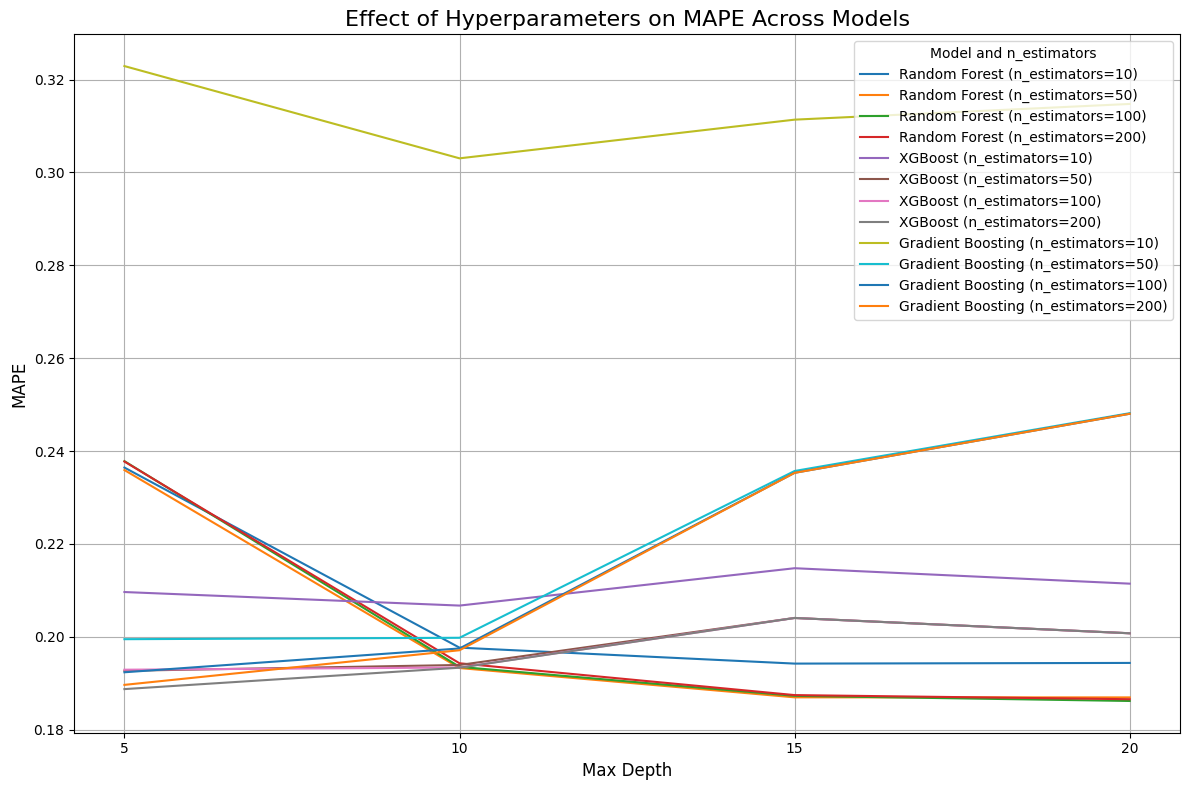

                Model  n_estimators  max_depth      MAPE
0       Random Forest            10          5  0.236450
1       Random Forest            10         10  0.197667
2       Random Forest            10         15  0.194232
3       Random Forest            10         20  0.194376
4       Random Forest            50          5  0.235914
5       Random Forest            50         10  0.193276
6       Random Forest            50         15  0.186965
7       Random Forest            50         20  0.186952
8       Random Forest           100          5  0.237831
9       Random Forest           100         10  0.193533
10      Random Forest           100         15  0.187286
11      Random Forest           100         20  0.186182
12      Random Forest           200          5  0.237751
13      Random Forest           200         10  0.194301
14      Random Forest           200         15  0.187448
15      Random Forest           200         20  0.186559
16            XGBoost          

In [13]:
# Evaluate hypeparameters : max_depht and n_estimators for the last 3 models that show better performance

def evaluate_hyperparameters(X_train, y_train, X_test, y_test, 
                              n_estimators_values, max_depth_values,
                              models_to_evaluate=['Random Forest', 'XGBoost', 'Gradient Boosting']):
    """
    Evaluate the effect of n_estimators and max_depth on MAPE for Random Forest, XGBoost, and Gradient Boosting models.

    Parameters:
        X_train (array-like): Training features.
        y_train (array-like): Training target.
        X_test (array-like): Test features.
        y_test (array-like): Test target.
        n_estimators_values (list): List of n_estimators values to test.
        max_depth_values (list): List of max_depth values to test.
        models_to_evaluate (list): Models to include ('Random Forest', 'XGBoost', 'Gradient Boosting').

    Returns:
        pd.DataFrame: A DataFrame containing MAPE results for all hyperparameter combinations and models.
    """
    results = []

    for model_name in models_to_evaluate:
        print(f"Evaluating {model_name}...")
        for n_estimators in n_estimators_values:
            for max_depth in max_depth_values:
                # Initialize the model with current hyperparameters
                if model_name == 'Random Forest':
                    model = RandomForestRegressor(n_estimators=n_estimators, 
                                                  max_depth=max_depth, 
                                                  random_state=42)
                elif model_name == 'XGBoost':
                    model = XGBRegressor(n_estimators=n_estimators, 
                                         max_depth=max_depth, 
                                         random_state=42, 
                                         verbosity=0)
                elif model_name == 'Gradient Boosting':
                    model = GradientBoostingRegressor(n_estimators=n_estimators, 
                                                      max_depth=max_depth, 
                                                      random_state=42)
                else:
                    raise ValueError(f"Model {model_name} is not supported.")

                # Train the model
                model.fit(X_train, y_train)

                # Make predictions
                y_pred = model.predict(X_test)

                # Calculate MAPE
                mape = mean_absolute_percentage_error(y_test, y_pred)

                # Store the results
                results.append({
                    'Model': model_name,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'MAPE': mape
                })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plot the results
    plt.figure(figsize=(12, 8))
    for model_name in models_to_evaluate:
        subset = results_df[results_df['Model'] == model_name]
        for n_estimators in n_estimators_values:
            subset_estimators = subset[subset['n_estimators'] == n_estimators]
            plt.plot(subset_estimators['max_depth'].astype(str), 
                     subset_estimators['MAPE'], 
                     label=f'{model_name} (n_estimators={n_estimators})')

    # Customize plot
    plt.xlabel('Max Depth', fontsize=12)
    plt.ylabel('MAPE', fontsize=12)
    plt.title('Effect of Hyperparameters on MAPE Across Models', fontsize=16)
    plt.legend(title='Model and n_estimators', fontsize=10, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

n_estimators_values = [10, 50, 100, 200]
max_depth_values = [5, 10, 15, 20]

results_df = evaluate_hyperparameters(X_train, y_train, X_test, y_test, 
                                       n_estimators_values, max_depth_values, 
                                       models_to_evaluate=['Random Forest', 'XGBoost', 'Gradient Boosting'])

# Display the results
print(results_df)


Normally 5 or 10 max_depth shows the best MAPE

### Best models, Feature Importance
Checking r2 and MAPE for test set, with all the variables and without parameter definition to asses weather is necessary to add other variables in non-linear models.

Training XGBoost...
XGBoost MAPE: 17.20%
XGBoost R²: 0.8218
XGBoost Top Features:
                         Feature  Importance
4                      bathrooms    0.393164
2                           size    0.123796
19                price_m2_oct24    0.086514
9                        hasLift    0.054194
18  parkingSpace.hasParkingSpace    0.041332
24                 amenity.score    0.027912
8                 newDevelopment    0.022273
16                         floor    0.021215
5                       distance    0.019952
7                         status    0.018150
28            district_Les Corts    0.017548
22            room.to.size.ratio    0.015488
17                      exterior    0.015272
23  room+bathrooms.to.size.ratio    0.014297
1                   propertyType    0.012805
15    highlight.groupDescription    0.012432
20                   monthly_var    0.010824
26               district_Gràcia    0.010272
12                        has360    0.009368
30          distri

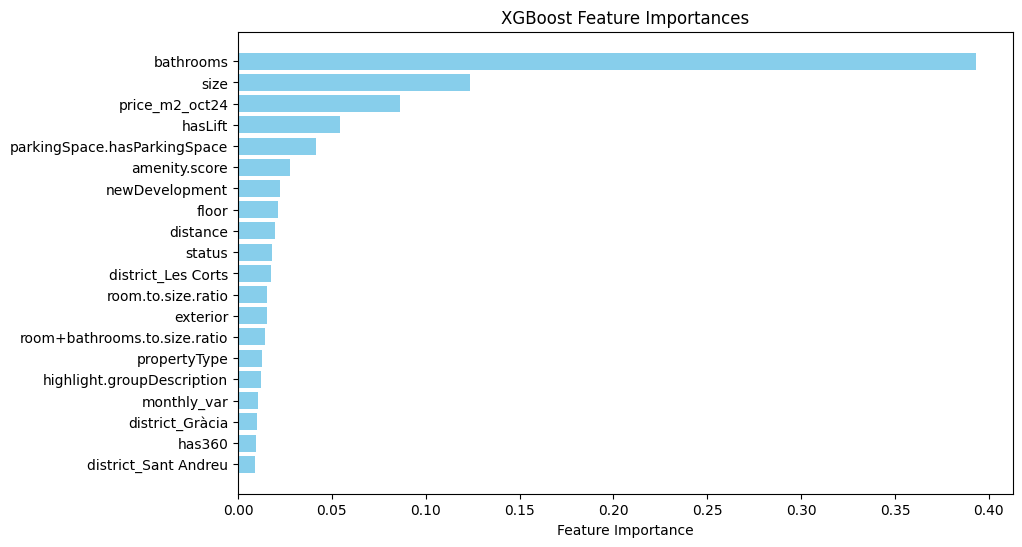

Training Gradient Boosting...
Gradient Boosting MAPE: 18.07%
Gradient Boosting R²: 0.8142
Gradient Boosting Top Features:
                         Feature  Importance
2                           size    0.402840
4                      bathrooms    0.268461
19                price_m2_oct24    0.086960
5                       distance    0.056663
23  room+bathrooms.to.size.ratio    0.028231
9                        hasLift    0.027839
16                         floor    0.026626
0                      numPhotos    0.022461
22            room.to.size.ratio    0.020292
24                 amenity.score    0.016452
18  parkingSpace.hasParkingSpace    0.010341
15    highlight.groupDescription    0.007004
8                 newDevelopment    0.005102
1                   propertyType    0.003971
20                   monthly_var    0.003895
7                         status    0.003540
17                      exterior    0.001570
33  district_Sarrià-Sant Gervasi    0.001486
25             district

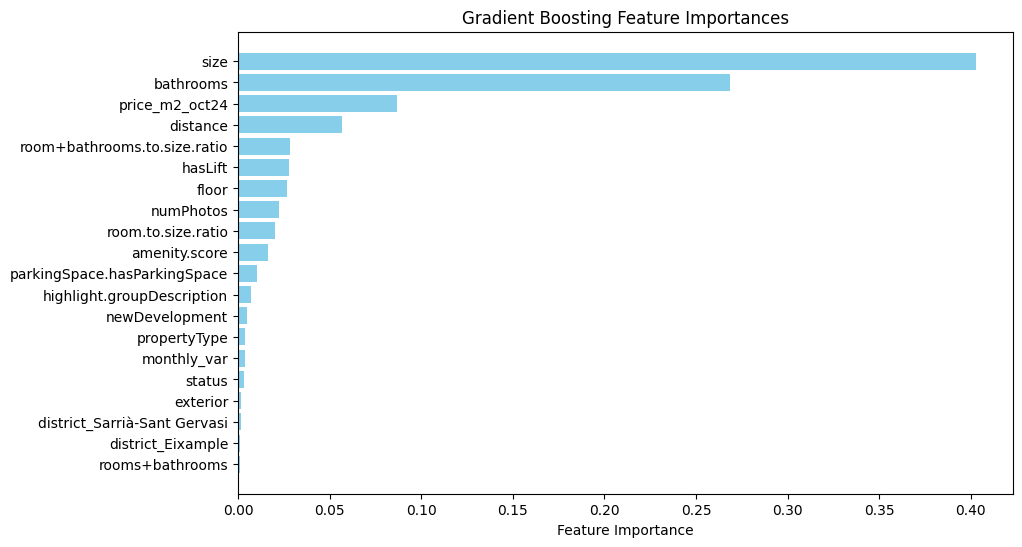

In [17]:
def evaluate_models(df, target_column, models_to_evaluate=['Random Forest', 'XGBoost', 'Gradient Boosting']):
    """
    Train models (Random Forest, XGBoost, Gradient Boosting), calculate MAPE and R², and display feature importances.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features and target.
        target_column (str): The name of the target column.
        models_to_evaluate (list): List of models to evaluate ('Random Forest', 'XGBoost', 'Gradient Boosting').

    Returns:
        dict: A dictionary containing MAPE, R², and feature importance DataFrames for each model.
    """
    # Split features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Results dictionary to store MAPE, R², and feature importances
    results = {}

    for model_name in models_to_evaluate:
        print(f"Training {model_name}...")

        # Initialize the model
        if model_name == 'Random Forest':
            model = RandomForestRegressor(random_state=42)
        elif model_name == 'XGBoost':
            model = XGBRegressor(random_state=42, verbosity=0)
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingRegressor(random_state=42)
        else:
            raise ValueError(f"Model {model_name} is not supported.")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate MAPE and R²
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} MAPE: {mape * 100:.2f}%")
        print(f"{model_name} R²: {r2:.4f}")

        # Get feature importances if available
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
        else:
            feature_importances = [0] * X.shape[1]  # Placeholder if model does not provide feature importances

        # Create a DataFrame for feature importances
        features_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False).head(20)

        # Print the top features
        print(f"{model_name} Top Features:")
        print(features_df)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} Feature Importances')
        plt.gca().invert_yaxis()  # Most important feature on top
        plt.show()

        # Save results in the dictionary
        results[model_name] = {
            'MAPE': mape,
            'R²': r2,
            'Feature Importances': features_df
        }

    return results

results = evaluate_models(df, target_column='price', models_to_evaluate=['XGBoost', 'Gradient Boosting'])



Models r^2 do not improve more than 0.2, showing that is not necessary to add more variables to the models.

## Evaluation of the 5 models, for comparisson with the best hyperparameters already chosen in an excel file
This will be automatized in the train_and_evaluate_models.py

In [18]:
# Folder to save evaluation metrics
metrics_folder = os.path.join(project_root, 'modelling/modelling_comparisson_metrics')
metrics_file_path = os.path.join(metrics_folder, 'model_comparison_metrics.xlsx')

# Function to prepare features and target variables
def prepare_data(df: pd.DataFrame ) -> (pd.DataFrame, pd.Series):
    """Split the DataFrame into features (X) and target (y)."""
    X = df[['numPhotos', 'size', 'distance', 'bathrooms', 'hasLift', 'price_m2_oct24', 'amenity.score', 'floor', 
            'propertyType', 'highlight.groupDescription', 'exterior', 'parkingSpace.hasParkingSpace']]
    y = df['price']
    return X, y


In [20]:
# Function to calculate metrics (replace with your actual implementation)
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # Mean Error (ME)
    me = np.mean(y_pred - y_true)
    
    # Mean Percentage Error (MPE)
    mpe = np.mean((y_pred - y_true) / y_true)

    return r2, rmse, mae, mape, me, mpe

# Function to save evaluation metrics to Excel
def save_metrics_to_excel(metrics: dict) -> None:
    """Save evaluation metrics to an Excel file, appending in the next available row."""
    # Create a DataFrame from the metrics dictionary
    df_metrics = pd.DataFrame([metrics])
    
    # Check if the Excel file exists
    if os.path.exists(metrics_file_path):
        # Open the existing workbook
        wb = load_workbook(metrics_file_path)
        sheet = wb['Metrics']
        
        # Find the first empty row
        next_row = sheet.max_row + 1
        
        # Write the data starting from the next empty row
        for r_idx, row in enumerate(df_metrics.values, next_row):
            for c_idx, value in enumerate(row, 1):
                sheet.cell(row=r_idx, column=c_idx, value=value)
        
        # Save the workbook
        wb.save(metrics_file_path)
    else:
        # Create a new file and add the headers
        with pd.ExcelWriter(metrics_file_path, engine='openpyxl') as writer:
            df_metrics.to_excel(writer, index=False, sheet_name='Metrics')

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # Mean Error (ME) and Mean Percentage Error (MPE) calculations
    me = np.mean(y_true - y_pred)
    mpe = np.mean((y_true - y_pred) / y_true)  # As percentage

    return r2, rmse, mae, mape, me, mpe

# Function to save evaluation metrics to Excel
def save_metrics_to_excel(metrics: dict) -> None:
    """Save evaluation metrics to an Excel file, appending in the next available row."""

    # Create a DataFrame from the metrics dictionary
    df_metrics = pd.DataFrame([metrics])
    
    # Check if the Excel file exists
    if os.path.exists(metrics_file_path):
        # Open the existing workbook
        wb = load_workbook(metrics_file_path)
        sheet = wb['Metrics']
        
        # Find the first empty row
        next_row = sheet.max_row + 1
        
        # Write the data starting from the next empty row
        for r_idx, row in enumerate(df_metrics.values, next_row):
            for c_idx, value in enumerate(row, 1):
                sheet.cell(row=r_idx, column=c_idx, value=value)
        
        # Save the workbook
        wb.save(metrics_file_path)
    else:
        # Create a new file and add the headers
        with pd.ExcelWriter(metrics_file_path, engine='openpyxl') as writer:
            df_metrics.to_excel(writer, index=False, sheet_name='Metrics')

# Function to train and evaluate the linear regression model
def run_linear_regression(df):
    """Train and evaluate linear regression model using cross-validation for all metrics."""
    # Prepare data
    X, y = prepare_data(df)
    
    # Scale the features (excluding 'price' from scaling)
    scaler_features = StandardScaler()
    X_scaled = scaler_features.fit_transform(X)

    # Scale the target variable 'price' separately
    scaler_target = StandardScaler()
    y_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))

    # Initialize model
    model = LinearRegression()
    
    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize lists to collect metrics for training and testing
    train_r2_list, train_rmse_list, train_mae_list, train_mape_list, train_me_list, train_mpe_list = [], [], [], [], [], []
    test_r2_list, test_rmse_list, test_mae_list, test_mape_list, test_me_list, test_mpe_list = [], [], [], [], [], []
    
    for train_idx, test_idx in cv.split(X_scaled, y_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions for training and testing data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Inverse transform the scaled target values back to original scale
        y_train_original = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_pred_train_original = scaler_target.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()

        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_test_original = scaler_target.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
        
        # Calculate and append metrics for training data
        train_r2, train_rmse, train_mae, train_mape, train_me, train_mpe = calculate_metrics(y_train_original, y_pred_train_original)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_mape_list.append(train_mape)
        train_me_list.append(train_me)
        train_mpe_list.append(train_mpe)
        
        # Calculate and append metrics for testing data
        test_r2, test_rmse, test_mae, test_mape, test_me, test_mpe = calculate_metrics(y_test_original, y_pred_test_original)
        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        test_mae_list.append(test_mae)
        test_mape_list.append(test_mape)
        test_me_list.append(test_me)
        test_mpe_list.append(test_mpe)
    
    # Compute mean metrics for cross-validation
    mean_train_r2 = np.mean(train_r2_list)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_train_mae = np.mean(train_mae_list)
    mean_train_mape = np.mean(train_mape_list)
    mean_train_me = np.mean(train_me_list)
    mean_train_mpe = np.mean(train_mpe_list)
    
    mean_test_r2 = np.mean(test_r2_list)
    mean_test_rmse = np.mean(test_rmse_list)
    mean_test_mae = np.mean(test_mae_list)
    mean_test_mape = np.mean(test_mape_list)
    mean_test_me = np.mean(test_me_list)
    mean_test_mpe = np.mean(test_mpe_list)

    # Collect results
    results = pd.DataFrame({
        'date': [pd.Timestamp.today().strftime('%Y-%m-%d')],
        'model_type': ['Linear Regression'],
        'predictor_variables': ['numPhotos, size, distance, bathrooms, hasLift, price_m2_oct24, amenity.score, floor, propertyType, highlight.groupDescription, exterior, parkingSpace.hasParkingSpace'],
        'train_r2_mean': [mean_train_r2],
        'train_rmse_mean': [mean_train_rmse],
        'train_mae_mean': [mean_train_mae],
        'train_mape_mean': [mean_train_mape],
        'train_me_mean': [mean_train_me],
        'train_mpe_mean': [mean_train_mpe],
        'test_r2_mean': [mean_test_r2],
        'test_rmse_mean': [mean_test_rmse],
        'test_mae_mean': [mean_test_mae],
        'test_mape_mean': [mean_test_mape],
        'test_me_mean': [mean_test_me],
        'test_mpe_mean': [mean_test_mpe],
    })
    
    print(results)
    # Save results to Excel
    save_metrics_to_excel(results.to_dict(orient='records')[0])

run_linear_regression(df)


         date         model_type  \
0  2024-12-15  Linear Regression   

                                 predictor_variables  train_r2_mean  \
0  numPhotos, size, distance, bathrooms, hasLift,...       0.730321   

   train_rmse_mean  train_mae_mean  train_mape_mean  train_me_mean  \
0     96959.760034    73896.110885         0.211476  -2.827522e-11   

   train_mpe_mean  test_r2_mean  test_rmse_mean  test_mae_mean  \
0        -0.05678      0.725122    97670.906403   74458.454014   

   test_mape_mean  test_me_mean  test_mpe_mean  
0        0.213165    -60.868629      -0.057328  


In [21]:
# Models and their parameters
models_params = {
    'decision_tree': {
        'model': DecisionTreeRegressor(
            min_samples_split=30,  
            min_samples_leaf=15,  
            max_depth=6           
        ), 
        'name': 'Decision Tree'
    },
    'random_forest': {
        'model': RandomForestRegressor(
            n_estimators=100,     
            min_samples_split=10, 
            min_samples_leaf=5,   
            max_depth=15,         
            max_features='log2'   
        ), 
        'name': 'Random Forest'
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(
            subsample=0.7,        
            n_estimators=150,      
            min_samples_split=10,  
            min_samples_leaf=5, 
            max_depth=5,         
            learning_rate=0.05   
        ), 
        'name': 'Gradient Boosting'
    },
    'xgboost': {
        'model': XGBRegressor(
            subsample=0.8,        
            reg_lambda=1,          
            reg_alpha=0.1,         
            n_estimators=150,     
            max_depth=4,           
            learning_rate=0.1,    
            colsample_bytree=0.6   
        ), 
        'name': 'XGBoost'
    }
}
# Function to run and evaluate the models
def run_other_models(df):
    """Train and evaluate models without feature scaling."""
    # Prepare data (replace with your actual data preparation function)
    X, y = prepare_data(df)

    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize list to collect all results
    all_results = []
    
    for model_name, model_info in models_params.items():
        if model_name == 'linear_regression':
            continue  # Skip linear regression as it is already handled separately
        
        model = model_info['model']
        model_type = model_info['name']
        
        # Initialize lists to collect metrics for training and testing
        train_r2_list, train_rmse_list, train_mae_list, train_mape_list, train_me_list, train_mpe_list = [], [], [], [], [], []
        test_r2_list, test_rmse_list, test_mae_list, test_mape_list, test_me_list, test_mpe_list = [], [], [], [], [], []
        
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions for training and testing data
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Calculate and append metrics for training data
            train_r2, train_rmse, train_mae, train_mape, train_me, train_mpe = calculate_metrics(y_train, y_pred_train)
            train_r2_list.append(train_r2)
            train_rmse_list.append(train_rmse)
            train_mae_list.append(train_mae)
            train_mape_list.append(train_mape)
            train_me_list.append(train_me)
            train_mpe_list.append(train_mpe)
            
            # Calculate and append metrics for testing data
            test_r2, test_rmse, test_mae, test_mape, test_me, test_mpe = calculate_metrics(y_test, y_pred_test)
            test_r2_list.append(test_r2)
            test_rmse_list.append(test_rmse)
            test_mae_list.append(test_mae)
            test_mape_list.append(test_mape)
            test_me_list.append(test_me)
            test_mpe_list.append(test_mpe)
        
        # Compute mean metrics for cross-validation
        mean_train_r2 = np.mean(train_r2_list)
        mean_train_rmse = np.mean(train_rmse_list)
        mean_train_mae = np.mean(train_mae_list)
        mean_train_mape = np.mean(train_mape_list)
        mean_train_me = np.mean(train_me_list)
        mean_train_mpe = np.mean(train_mpe_list)
        
        mean_test_r2 = np.mean(test_r2_list)
        mean_test_rmse = np.mean(test_rmse_list)
        mean_test_mae = np.mean(test_mae_list)
        mean_test_mape = np.mean(test_mape_list)
        mean_test_me = np.mean(test_me_list)
        mean_test_mpe = np.mean(test_mpe_list)

        # Collect results for the current model
        results = pd.DataFrame({
            'date': [pd.Timestamp.today().strftime('%Y-%m-%d')],
            'model_type': [model_type],
            'predictor_variables': ['numPhotos, size, distance, bathrooms, hasLift, price_m2_oct24, amenity.score, floor, propertyType, highlight.groupDescription, exterior, parkingSpace.hasParkingSpace'],
            'train_r2_mean': [mean_train_r2],
            'train_rmse_mean': [mean_train_rmse],
            'train_mae_mean': [mean_train_mae],
            'train_mape_mean': [mean_train_mape],
            'train_me_mean': [mean_train_me],
            'train_mpe_mean': [mean_train_mpe],
            'test_r2_mean': [mean_test_r2],
            'test_rmse_mean': [mean_test_rmse],
            'test_mae_mean': [mean_test_mae],
            'test_mape_mean': [mean_test_mape],
            'test_me_mean': [mean_test_me],
            'test_mpe_mean': [mean_test_mpe],
        })
        
        # Save the results to Excel
        save_metrics_to_excel(results.to_dict('records')[0])

        all_results.append(results)

    return all_results

# Example to run the function
run_other_models(df)


[         date     model_type  \
 0  2024-12-15  Decision Tree   
 
                                  predictor_variables  train_r2_mean  \
 0  numPhotos, size, distance, bathrooms, hasLift,...       0.742905   
 
    train_rmse_mean  train_mae_mean  train_mape_mean  train_me_mean  \
 0     94666.361848    70627.646708         0.202668  -3.928250e-12   
 
    train_mpe_mean  test_r2_mean  test_rmse_mean  test_mae_mean  \
 0          -0.065      0.672991   106484.557476   79599.397097   
 
    test_mape_mean  test_me_mean  test_mpe_mean  
 0        0.230461   -264.711471      -0.076569  ,
          date     model_type  \
 0  2024-12-15  Random Forest   
 
                                  predictor_variables  train_r2_mean  \
 0  numPhotos, size, distance, bathrooms, hasLift,...       0.847157   
 
    train_rmse_mean  train_mae_mean  train_mape_mean  train_me_mean  \
 0     72990.895005    53667.307183          0.15501     -10.653663   
 
    train_mpe_mean  test_r2_mean  test_rmse_mea